### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler



#import statmorph
import time

import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [3]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

good_gids = np.array([gal['img_name'] for gal in all_gals])
cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

In [4]:
## Runtime config.

fields = ['gini', 'm20', 'asymmetry']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'

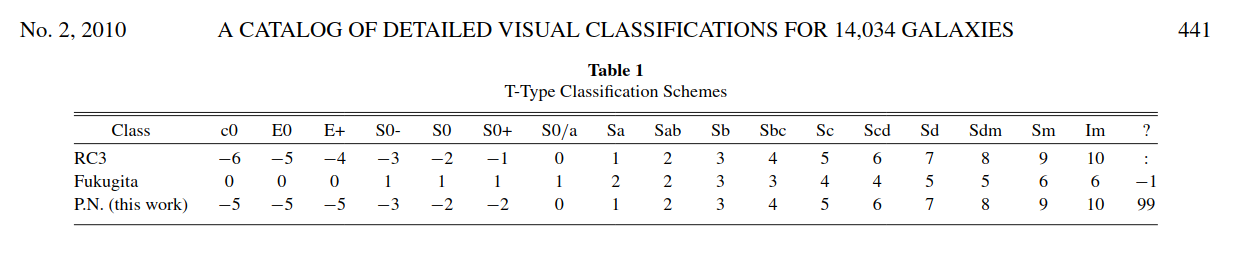

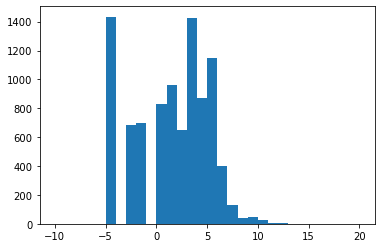

In [4]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

### Test evaluate

Need to be dl > dh ? 

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



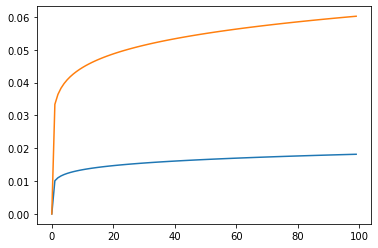

In [51]:
from astrobf.tmo import Mantiuk_Seidel
for i in [0,1]:
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(params, f"{i}")))

In [9]:
importlib.reload(custom_morph)

<module 'astrobf.morph.custom_morph' from '/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py'>

In [13]:
def get_morph(gals, tmo_params, ind):
    if ind is None:
        ind = np.arange(len(gals))
        ngal = len(gals)
    else:
        ngal = len(ind)

    result_arr = np.zeros(ngal, 
                      dtype=[('id','<U24'),('ttype',int), ('size', float)]
                           +[(ff,float) for ff in fields])
    
    for i, ii in enumerate(ind):
        #if i <300: #
        #    continue #
        t0 = time.time() #
        this_gal = gals[ii]
        mi = custom_morph.MorphImg(this_gal['data'], tmo_params, gid=this_gal['img_name'])
        check = mi.measure_all()
        if check < -90:
            print("ERROR in {i}-th galaxy")
            return ['bad', np.sum((result_arr[i]['gini'],result_arr[i]['m20']))]
        if np.sum(mi._tonemapped) <= 0:
            return ['bad', np.sum(mi._tonemapped)]
        result_arr[i]['id'] = this_gal['img_name']
        result_arr[i]['gini'] = mi.Gini
        result_arr[i]['m20']  = mi.M20
        result_arr[i]['asymmetry'] = mi.Asym
        #print(i, "took {:.4f}".format(time.time() - t0)) #
        if result_arr[i]['gini'] < -90 or result_arr[i]['m20'] < -90 or result_arr[i]['asymmetry'] < -90:
            print("ERROR in {i}-th galaxy")
            return ['bad', np.sum((result_arr[i]['gini'],result_arr[i]['m20']))]
    return result_arr

In [6]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(get_morph(sub_gals, 
                                     plist[i], 
                                     np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    #print("gini", result_arr['gini'].min(), result_arr['gini'].max(),
    #      result_arr['gini'].mean(), result_arr['gini'].std())
    #print("m20", result_arr['m20'].min(), result_arr['m20'].max(),
    #      result_arr['m20'].mean(), result_arr['m20'].std())
    #print("asymmetry", result_arr['asymmetry'].min(), result_arr['asymmetry'].max(),
    #      result_arr['asymmetry'].mean(), result_arr['asymmetry'].std())
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=fields, 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

# Test evaluate

In [11]:
params = {'b0': 6.5994335621336555,
         'c0': 3.8522801643712445,
         'dl0': 13.850014672900969,
         'dh0': 1.0,
         'b1': 6.129207334451078,
         'c1': 1.207514275741114,
         'dl1': 13.0,
         'dh1': 2.0380281794991895,
         'b2': 6.5994335621336555,
         'c2': 3.8522801643712445,
         'dl2': 13.850014672900969,
         'dh2': 1.0,
         'b3': 6.129207334451078,
         'c3': 7.207514275741114,
         'dl3': 1.0,
         'dh3': 6.0380281794991895}

ngroups = 4
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of sub sample: 7095


In [14]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'
for ngroups in [2,4,6,8][1:]:
    this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
    ax_params = mucl.gen_tmo_param_sets(ngroups)
        
    subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)
    subcat = subcat[:800]

    print("# of sub sample: {}".format(len(subcat)))

    sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]
    
        
    for fn_result, cluster_method in zip([f"FMS_{ngroups}G_ward_asym",
                                          f"FMS_{ngroups}G_agg_asym",
                                          f"FMS_{ngroups}G_spec_asym"][:1],
                                         ['ward', 'agglomerate', 'spectral'][:1]):

        axc = AxClient()

        axc.create_experiment(
            parameters=ax_params,
            objective_name="mymetric",
            #minimize=True,  # Optional, defaults to False.
            parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(ngroups)] + \
                                  [f"dl{i} - dh{i} >= 0.1" for i in range(ngroups)], # all images are stretched to 100
            overwrite_existing_experiment =True,
            outcome_constraints=["total_flux >= 1e-5"],  # Optional.
        )

        all_metrics=[] # appended inside evaluate()
        for i in range(50):
            parameters, trial_index = axc.get_next_trial()
            axc.complete_trial(trial_index=trial_index,
                               raw_data=evaluate(parameters,
                                                 cluster_method=cluster_method))

        pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

        if True:
            axc.save_to_json_file(exp_dir+fn_result+"sm800.json")
        else:
            axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[INFO 06-04 10:23:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 06-04 10:23:04] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 16 trials, GPEI for subsequent trials]). Iterations after 16 will take longer to generate due to  model-fitting.
[INFO 06-04 10:23:04] ax.service.ax_client: Generated new trial 0 with parameters {'b0': 2.1, 'c0': 5.46, 'dl0': 7.6, 'dh0': 

# of sub sample: 800


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/

KeyboardInterrupt: 

In [10]:
axc.save_to_json_file(exp_dir+fn_result+"small.json")

[INFO 06-04 01:51:34] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_6G_ward_asymsmall.json`.


## a posteriori analysis

In [16]:
exp_dir="./Experiments/"
ngroups=2
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)
axc = AxClient.load_from_json_file(exp_dir+'FMS_4G_ward_asymsm800'+'.json')

[INFO 06-04 10:23:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 30_0, 42_0, 34_0, 37_0, 31_0, 36_0, 49_0
[INFO 06-04 10:23:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [19]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

NameError: name 'all_metrics' is not defined

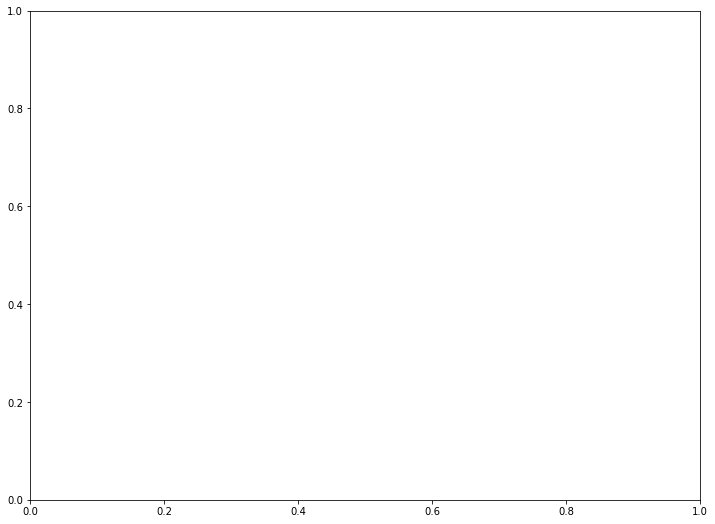

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10



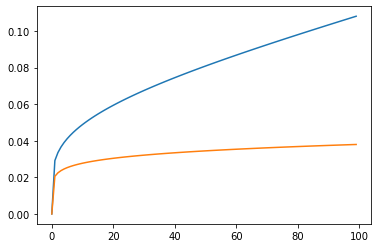

In [17]:
best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
for i in range(ngroups):
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(best_parameters, f"{i}")))
    

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [ ]:
from astrobf import analysis

best_parameters, values = axc.get_best_parameters()

plist = [mucl.ext_single_param(best_parameters, f"{i}") for i in range(ngroups)]

subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)
subcat = subcat[:800]

print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]


best_results = []
for i in range(ngroups):
    best_results.append(get_morph(sub_gals, 
                                 plist[i], 
                                 np.where(subcat['label'] == i)[0]))

# merge and sort
result_arr = np.concatenate(best_results)
result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
inds = result_arr['id'].searchsorted(subcat["ID"])
result_arr = result_arr[inds]
#best_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)

#best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, subcat)

#best_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin), subcat,
#                                         fields=['gini', 'm20', 'asymmetry'], 
#                                         n_clusters=ngroups,
#                                         return_cluster=True,
#                                         cluster_method="ward",
#                                         eval_weight='area')

nbest_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin),
                                                     subcat, n_clusters=ngroups,
                                                     return_cluster=True,
                                                      fields=fields, 
                                                      cluster_method=cluster_method,
                                                      eval_weight='area')

# of sub sample: 800


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/

7747


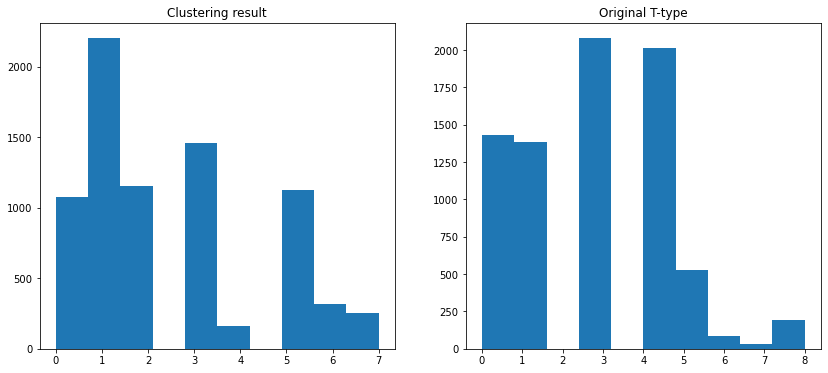

In [17]:
print(len(best_clustering.labels_))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].hist(best_clustering.labels_)
axs[0].set_title("Clustering result")
axs[1].hist(labeler(subcat, bins=this_bin, field='TT'))
axs[1].set_title("Original T-type")

plt.show()

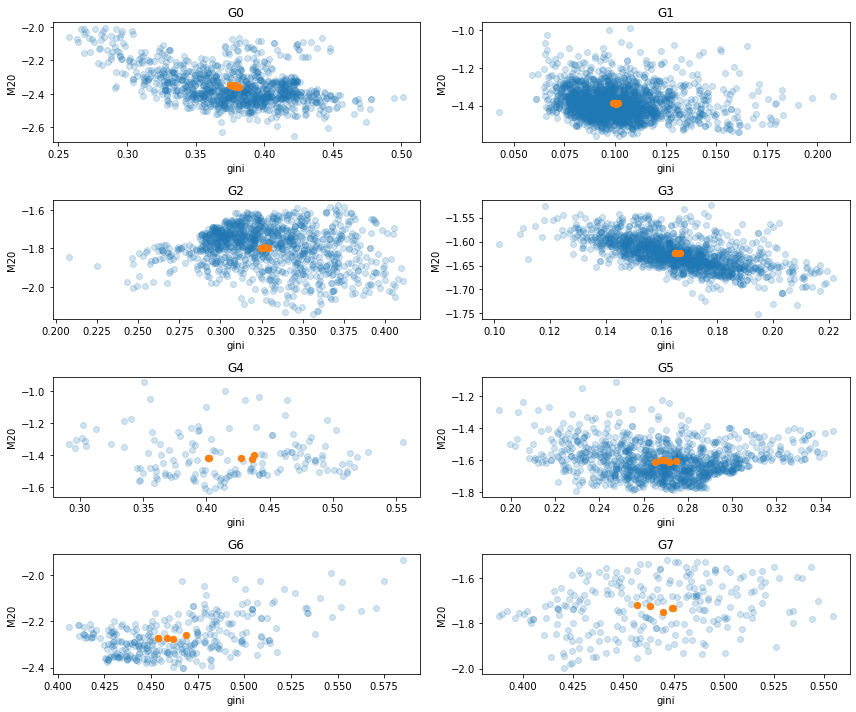

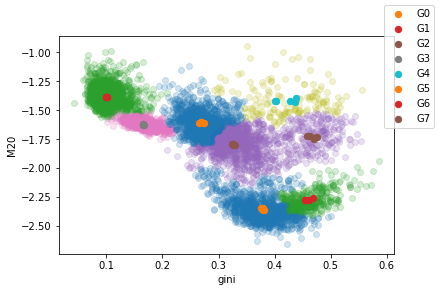

In [19]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(4,2)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.show()

In [21]:
mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=exp_dir+fn_result+"groups_comp.png")

mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=exp_dir+fn_result+"groups_log.png")


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:80: RuntimeWarning:

divide by zero encountered in log10



## Typical sampes at incremental points 

### Get the 'incremental' points

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



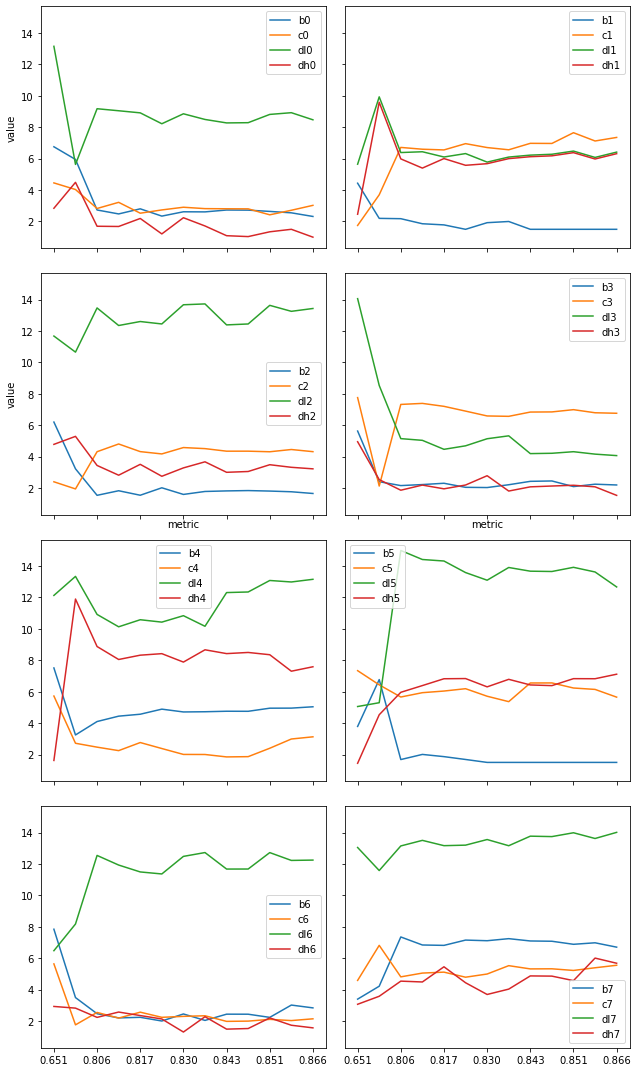

In [24]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(4,2, sharex=True, sharey=True)
fig.set_size_inches(9,15)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.savefig(fn_result+"param_evol.png")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [162]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [25]:
# Typicals defined above

clu_best = [best_results[best_clustering.labels_ == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=fn_result+f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    this_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=['gini', 'm20'], 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,
                                     eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_clustering.labels_ == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=fn_result+f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=fn_result+f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


## Backup

In [17]:
from functools import partial

def evaluate_org(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}